In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
import joblib
import seaborn as sns
import matplotlib.pyplot as plt




In [22]:
# Cargar los dos archivos CSV por separado
df_red = pd.read_csv(r"C:\Users\delam\OneDrive\Ironhack\Proyectos Boot Camp\Proyecto-machine-learning\Data\winequality-red.csv", sep=';')
df_white = pd.read_csv(r"C:\Users\delam\OneDrive\Ironhack\Proyectos Boot Camp\Proyecto-machine-learning\Data\winequality-white.csv", sep=';')

# Agregar una columna de identificación al Target
df_red['type'] = 'red'
df_white['type'] = 'white'

# 3. Concatenar los DataFrames
df_vino_combinado = pd.concat([df_red, df_white], ignore_index=True)

In [23]:
df_vino_combinado.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [24]:
df_vino_combinado.shape

(6497, 13)

In [27]:
# Función de mapeo a 3 categorías (Malo/Regular/Bueno) con la nueva lógica
def map_quality_3_classes_v2(score):
    if score >= 7:
        return 2  # Bueno (Scores 7, 8, 9)
    elif score == 6:
        return 1  # Regular (Score 6)
    else: # Scores 3, 4, 5
        return 0  # Malo (Scores 3, 4, 5)

# Crear la nueva variable target, reemplazando las anteriores (si existen)
# (Asegúrate de que df_vino_combinado sea el nombre correcto de tu DataFrame)
df_vino_combinado['quality_clase_final'] = df_vino_combinado['quality'].apply(map_quality_3_classes_v2)

# Muestra el conteo de la nueva variable target
print("Nueva Distribución de 3 Clases:")
print(df_vino_combinado['quality_clase_final'].value_counts())

Nueva Distribución de 3 Clases:
quality_clase_final
1    2836
0    2384
2    1277
Name: count, dtype: int64


In [ ]:
# Revisar el balanceo porcentualmente de los datos para el estudio del target

porcentaje_clases_multi = df_vino_combinado['quality_clase_final'].value_counts(normalize=True) * 100

print("\n📊 Distribución de las 3 Clases (Porcentajes):")
print(porcentaje_clases_multi)


📊 Distribución de las 3 Clases (Porcentajes):
quality_clase_final
1    43.650916
0    36.693859
2    19.655225
Name: proportion, dtype: float64


In [32]:
# Definir Features y Target 

features = df_vino_combinado.drop(columns=['quality', 'quality_clase_5', 'quality_clase_4', 'quality_clase_final']) 
target = df_vino_combinado['quality_clase_final'] 

# Aplicar One-Hot Encoding a la variable 'type' (Si no lo hiciste antes)
features = pd.get_dummies(features, columns=['type'], drop_first=True) 

# Separación Entrenamiento/Prueba

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target
)

print(f"Forma de X_train (sin SMOTE): {X_train.shape}")
print(f"Distribución del nuevo target en y_train: \n{y_train.value_counts()}")

Forma de X_train (sin SMOTE): (5197, 12)
Distribución del nuevo target en y_train: 
quality_clase_final
1    2269
0    1907
2    1021
Name: count, dtype: int64


In [34]:
# Definir la estrategia de remuestreo
# La clase mayoritaria es la 1 (Regular), con un conteo aproximado en el train set de 2836 * 0.8 ≈ 2268.
# Vamos a intentar balancear todas las clases a 2000, dejando la Clase 1 en su conteo original para no sobrecargar el dataset.

smote_strategy = {
    0: 2000, # Malo
    1: 2269, # Regular (Conteo original en train set)
    2: 2000  # Bueno
}

sm = SMOTE(sampling_strategy=smote_strategy, random_state=42)

X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

print("\nDistribución de clases DESPUÉS de SMOTE:")
print(y_train_resampled.value_counts())


Distribución de clases DESPUÉS de SMOTE:
quality_clase_final
1    2269
2    2000
0    2000
Name: count, dtype: int64


In [35]:
# Estandarización de datos

# Inicializar el escalador
scaler = StandardScaler()

# 2. Aplicar FIT y TRANSFORM solo al conjunto de entrenamiento
X_train_scaled = scaler.fit_transform(X_train_resampled) 
y_train_scaled = y_train_resampled 

# 3. Aplicar SOLO TRANSFORM al conjunto de prueba
X_test_scaled = scaler.transform(X_test)

# Modelo KNN

In [36]:
knn = KNeighborsClassifier()

knn.fit(X_train_scaled, y_train_scaled)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [37]:
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", class_report)

Accuracy: 0.3646153846153846
Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.99      0.53       477
           1       0.33      0.00      0.00       567
           2       0.23      0.01      0.02       256

    accuracy                           0.36      1300
   macro avg       0.31      0.33      0.19      1300
weighted avg       0.33      0.36      0.20      1300



C:\Users\delam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [38]:
# Usamos Grid Search para encontrar el valor óptimo de k que dé la mejor precisión en los datos. 
# Para el knn usaremos los datos escalados.

# Definir el rango de k a probar
param_grid = {'n_neighbors': range(1, 21)}

# GridSearchCV con modelo KNN y los datos balanceados
grid_search = GridSearchCV(
    KNeighborsClassifier(), 
    param_grid, 
    cv=5, 
    scoring='accuracy' 
)
grid_search.fit(X_train_scaled, y_train_scaled)

# Obtener el mejor resultado
mejor_k = grid_search.best_params_['n_neighbors']
mejor_score = grid_search.best_score_
print(f"El mejor valor de k es: {mejor_k} con un score de: {mejor_score:.4f}")

El mejor valor de k es: 1 con un score de: 0.7175


In [39]:
# Construir el modelo KNN final con el valor óptimo de k=1 y evaluarlo con el conjunto de prueba para obtener su rendimiento real.

# Iniciar el modelo con k=1
knn_final = KNeighborsClassifier(n_neighbors=1)

# Entrenar el modelo
knn_final.fit(X_train_scaled, y_train_scaled)

# Generar predicciones en el conjunto de PRUEBA NO BALANCEADO
y_pred_final = knn_final.predict(X_test)

# Evaluar la precisión final y el reporte de clasificación
final_accuracy = accuracy_score(y_test, y_pred_final)

print(f"\nPrecisión Final en el Conjunto de Prueba (k=1): {final_accuracy:.4f}")

# El reporte de clasificación es esencial para datos desbalanceados
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_final))


Precisión Final en el Conjunto de Prueba (k=1): 0.3669

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.37      1.00      0.54       477
           1       0.00      0.00      0.00       567
           2       0.00      0.00      0.00       256

    accuracy                           0.37      1300
   macro avg       0.12      0.33      0.18      1300
weighted avg       0.13      0.37      0.20      1300



C:\Users\delam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\Users\delam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\delam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d

# Regresión Logística

In [40]:
# Regresión logística con los datos balanceados y estandarizados.

# Iniciar y entrenar el modelo 
log_reg_model = LogisticRegression(
    max_iter=500,       
    random_state=42, 
    multi_class='auto'  
) 

log_reg_model.fit(X_train_scaled, y_train_resampled)

# Generar predicciones 
y_pred_log_reg = log_reg_model.predict(X_test_scaled)

# Evaluar
print("\n--- Reporte de Clasificación (Regresión Logística) ---")
print(classification_report(y_test, y_pred_log_reg, zero_division=0))


--- Reporte de Clasificación (Regresión Logística) ---
              precision    recall  f1-score   support

           0       0.64      0.64      0.64       477
           1       0.54      0.43      0.48       567
           2       0.44      0.65      0.53       256

    accuracy                           0.55      1300
   macro avg       0.54      0.57      0.55      1300
weighted avg       0.56      0.55      0.55      1300



C:\Users\delam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


# Árbol de Decisión

In [41]:
# En el árbol de decisión usaremos los datos sin escalar, ya que al hacer la prueba con datos escalados los resultados eran prácticamente nulos.

# Iniciar el Árbol de Decisión
dt_model = DecisionTreeClassifier(random_state=42)

# Entrenar el modelo con los datos balanceados (sin escalar)
dt_model.fit(X_train_resampled, y_train_resampled)

# Generar predicciones en el conjunto de PRUEBA NO BALANCEADO (sin escalar)
y_pred_dt = dt_model.predict(X_test)

# Evaluar el rendimiento
dt_accuracy = accuracy_score(y_test, y_pred_dt)

print(f"\nPrecisión Final en el Conjunto de Prueba (Árbol de Decisión Base): {dt_accuracy:.4f}")
print("\nReporte de Clasificación (Árbol de Decisión Base):")
print(classification_report(y_test, y_pred_dt, zero_division=0))


Precisión Final en el Conjunto de Prueba (Árbol de Decisión Base): 0.6538

Reporte de Clasificación (Árbol de Decisión Base):
              precision    recall  f1-score   support

           0       0.71      0.70      0.70       477
           1       0.66      0.61      0.63       567
           2       0.56      0.67      0.61       256

    accuracy                           0.65      1300
   macro avg       0.64      0.66      0.65      1300
weighted avg       0.66      0.65      0.65      1300



# Bagging

In [42]:
# Iniciamos el modelo
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42), 
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1
)

# Entrenar con datos balanceados SIN ESCALAR
bagging_model.fit(X_train_resampled, y_train_resampled)

# Generar predicciones en el conjunto de PRUEBA
y_pred_bagging = bagging_model.predict(X_test)

# Evaluación
bagging_accuracy = accuracy_score(y_test, y_pred_bagging)

print(f"\nPrecisión Final en el Conjunto de Prueba (Bagging Classifier Base): {bagging_accuracy:.4f}")
print("\nReporte de Clasificación (Bagging Classifier Base):")
print(classification_report(y_test, y_pred_bagging, zero_division=0))


Precisión Final en el Conjunto de Prueba (Bagging Classifier Base): 0.6800

Reporte de Clasificación (Bagging Classifier Base):
              precision    recall  f1-score   support

           0       0.76      0.74      0.75       477
           1       0.66      0.61      0.63       567
           2       0.60      0.71      0.65       256

    accuracy                           0.68      1300
   macro avg       0.67      0.69      0.68      1300
weighted avg       0.68      0.68      0.68      1300



# Random Forest

In [43]:
# Nuevamente usaremos los datos sin escalar

# Iniciar el modelo 
rf_base_model = RandomForestClassifier(random_state=42)

# Entrenar el modelo con los datos balanceados (sin escalar)
rf_base_model.fit(X_train_resampled, y_train_resampled)

# Generar predicciones en el conjunto de PRUEBA NO BALANCEADO (sin escalar)
y_pred_rf_base = rf_base_model.predict(X_test)

# Evaluar el rendimiento
rf_base_accuracy = accuracy_score(y_test, y_pred_rf_base)

print(f"\nPrecisión Final en el Conjunto de Prueba (Random Forest Base): {rf_base_accuracy:.4f}")
print("\nReporte de Clasificación (Random Forest Base):")
print(classification_report(y_test, y_pred_rf_base, zero_division=0))


Precisión Final en el Conjunto de Prueba (Random Forest Base): 0.7069

Reporte de Clasificación (Random Forest Base):
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       477
           1       0.69      0.65      0.67       567
           2       0.61      0.71      0.66       256

    accuracy                           0.71      1300
   macro avg       0.70      0.71      0.70      1300
weighted avg       0.71      0.71      0.71      1300



In [44]:
# Hacemos un tuneado del random forest usando el random grid

# Definición del modelo
rf_model = RandomForestClassifier(random_state=42)

# Grid para la búsqueda aleatoria 
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None], 
    'min_samples_split': [2, 5], 
    'min_samples_leaf': [1, 2, 4] 
}

# Aplicamos RandomizedSearchCV
rf_random_search = RandomizedSearchCV(
    estimator=rf_model, 
    param_distributions=rf_param_grid, 
    n_iter=10, 
    cv=5, 
    random_state=42, 
    scoring='f1_weighted', 
    n_jobs=-1 
)

# Entrenar el modelo con los datos balanceados SIN ESCALAR 
rf_random_search.fit(X_train_resampled, y_train_resampled)

# Obtener los mejores parámetros
print("\nMejores parámetros para Random Forest (Random Search):")
print(rf_random_search.best_params_)

# EVALUACIÓN DEL RANDOM FOREST OPTIMIZADO

# Obtener el mejor modelo
best_rf_model = rf_random_search.best_estimator_

# Generar predicciones en el conjunto de PRUEBA NO BALANCEADO
y_pred_rf_opt = best_rf_model.predict(X_test)

# Evaluación
rf_opt_accuracy = accuracy_score(y_test, y_pred_rf_opt)

print(f"\nPrecisión Final en el Conjunto de Prueba (Random Forest Optimizado): {rf_opt_accuracy:.4f}")
print("\nReporte de Clasificación (Random Forest Optimizado):")
print(classification_report(y_test, y_pred_rf_opt, zero_division=0))


Mejores parámetros para Random Forest (Random Search):
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}

Precisión Final en el Conjunto de Prueba (Random Forest Optimizado): 0.7054

Reporte de Clasificación (Random Forest Optimizado):
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       477
           1       0.69      0.65      0.67       567
           2       0.62      0.73      0.67       256

    accuracy                           0.71      1300
   macro avg       0.70      0.71      0.70      1300
weighted avg       0.71      0.71      0.71      1300



# Ada Boost

In [45]:
# Ada boost usando Random search para la selección de parámetros
# En Ada boost usaremos los datos sin escalar.

# Definición del modelo base: AdaBoost con un Decision Tree interno
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(random_state=42), random_state=42)

# La rejilla de parámetros simplificada
grid_rapida = {
    "n_estimators": [100, 200], # Número de árboles en AdaBoost
    "estimator__max_leaf_nodes": [500, 1000], # Hoja máxima del árbol interno
    "estimator__max_depth": [30, 50] # Profundidad máxima del árbol interno
}

# 1. Usar RandomizedSearchCV
# n_iter=10: Probaremos 10 combinaciones aleatorias.
# cv=5: Usamos 5-fold cross-validation.
model_rs = RandomizedSearchCV(
    estimator=ada_reg, 
    param_distributions=grid_rapida, 
    n_iter=10, 
    cv=5, 
    random_state=42,
    scoring='neg_mean_squared_error', # Usamos una métrica de regresión, ya que AdaBoostRegressor es de regresión
    n_jobs=-1 # Usa todos los núcleos de tu CPU para acelerar
)

# 2. Entrenar el modelo con los datos balanceados correctos
# Esto debería tomar mucho menos tiempo que el Grid Search
model_rs.fit(X_train_resampled, y_train_resampled)

C:\Users\delam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,estimator,AdaBoostRegre...ndom_state=42)
,param_distributions,"{'estimator__max_depth': [30, 50], 'estimator__max_leaf_nodes': [500, 1000], 'n_estimators': [100, 200]}"
,n_iter,10
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [47]:
print("Mejor combinación de hiperparámetros encontrada:")
print(model_rs.best_params_)

Mejor combinación de hiperparámetros encontrada:
{'n_estimators': 200, 'estimator__max_leaf_nodes': 500, 'estimator__max_depth': 50}


In [48]:
# 1. Obtener el mejor modelo encontrado por Random Search
best_ada_model = model_rs.best_estimator_

# 2. Generar Predicciones en el conjunto de PRUEBA NO BALANCEADO
# Nota: La predicción será un número continuo (porque es un Regressor), por lo que debemos redondearlo al entero más cercano (0, 1, 2)
y_pred_ada_cont = best_ada_model.predict(X_test)
y_pred_ada = np.rint(y_pred_ada_cont).astype(int) # Redondea al entero más cercano

# 3. Asegurar que las predicciones estén dentro del rango de clases (0, 1, 2)
# Esto es una limpieza extra necesaria cuando se usa un Regressor para clasificar
y_pred_ada[y_pred_ada < 0] = 0
y_pred_ada[y_pred_ada > 2] = 2

# 4. Evaluar la precisión final y el reporte de clasificación
final_accuracy = accuracy_score(y_test, y_pred_ada)

print(f"\nPrecisión Final en el Conjunto de Prueba (AdaBoost Optimizado): {final_accuracy:.4f}")
print("\nReporte de Clasificación (AdaBoost Optimizado):")
print(classification_report(y_test, y_pred_ada, zero_division=0))


Precisión Final en el Conjunto de Prueba (AdaBoost Optimizado): 0.7285

Reporte de Clasificación (AdaBoost Optimizado):
              precision    recall  f1-score   support

           0       0.82      0.73      0.77       477
           1       0.67      0.77      0.72       567
           2       0.71      0.65      0.68       256

    accuracy                           0.73      1300
   macro avg       0.73      0.71      0.72      1300
weighted avg       0.74      0.73      0.73      1300



# Gradient Boost

In [49]:
# Inicializar el modelo
gb_model = GradientBoostingClassifier(random_state=42)

# Entrenar con datos balanceados SIN ESCALAR
gb_model.fit(X_train_resampled, y_train_resampled)

# Generar predicciones en el conjunto de PRUEBA
y_pred_gb = gb_model.predict(X_test)

# Evaluación
gb_accuracy = accuracy_score(y_test, y_pred_gb)

print(f"\nPrecisión Final en el Conjunto de Prueba (Gradient Boosting Base): {gb_accuracy:.4f}")
print("\nReporte de Clasificación (Gradient Boosting Base):")
print(classification_report(y_test, y_pred_gb, zero_division=0))


Precisión Final en el Conjunto de Prueba (Gradient Boosting Base): 0.6046

Reporte de Clasificación (Gradient Boosting Base):
              precision    recall  f1-score   support

           0       0.69      0.68      0.69       477
           1       0.59      0.49      0.54       567
           2       0.50      0.71      0.59       256

    accuracy                           0.60      1300
   macro avg       0.60      0.63      0.61      1300
weighted avg       0.61      0.60      0.60      1300



#  Conclusiones y Modelo Definitivo

## Análisis Final del Rendimiento

El resultado del modelo AdaBoost Optimizado  demostró ser la solución más robusta y equilibrada para el problema de clasificación con desbalanceo.

* **Balanceo de F1-Score:** El F1-Score Ponderado de **$\mathbf{0.73}$** es excelente. Más importante aún, el rendimiento es similar en las tres clases ($\mathbf{0.77, 0.72, 0.68}$), lo que prueba que el modelo no se especializa solo en las clases mayoritarias.

* **Precisión de la Clase Crítica (Malo):** La **Precisión de $\mathbf{0.82}$** para la Clase 0 (**Malo**) es vital. Esto significa que cuando el modelo predice un vino como "Malo", tiene una alta fiabilidad, minimizando el riesgo de falsos positivos que podrían descartar un vino de calidad aceptable.

* **Decisión Metodológica Válida:** El éxito se debe a la combinación de dos decisiones estratégicas clave:
    1.  **Redefinición del Target:** La agrupación a 3 clases ($\text{Score} \le 5$ como Malo, $\text{Score}=6$ como Regular, $\text{Score} \ge 7$ como Bueno) mejoró la base del desbalanceo.
    2.  **Uso de SMOTE y AdaBoost:** La técnica de *oversampling* junto con el poder del *ensemble* AdaBoost optimizado permitió aprender patrones complejos de las clases minoritarias.


##  Declaración del Modelo Campeón

| Parámetro | Valor |
| :--- | :--- |
| **Modelo Final** | **AdaBoost Optimizado** |
| **Variable Objetivo** | 3 Clases  (Malo, Regular, Bueno) |
| **Rendimiento Clave** | **Accuracy General:** $0.73$ |
| **Métrica de Desbalanceo** | **Weighted F1-Score:** $0.73$ |

# Recrear y guardar el modelo ganador

In [75]:
# Definir los parámetros óptimos encontrados por el Random Search
parametros_optimos_ada = {
    'n_estimators': 200, 
    'estimator__max_leaf_nodes': 500, 
    'estimator__max_depth': 30
}

# Recrear el modelo AdaBoost Optimizado
mejor_ada_final = AdaBoostRegressor(    
    DecisionTreeRegressor(max_leaf_nodes=parametros_optimos_ada['estimator__max_leaf_nodes'], 
                          max_depth=parametros_optimos_ada['estimator__max_depth'], 
                          random_state=42),    
    n_estimators=parametros_optimos_ada['n_estimators'], 
    random_state=42
)

# Entrenar por última vez en todos los datos de entrenamiento balanceados
mejor_ada_final.fit(X_train_resampled, y_train_resampled)

# Guardar el modelo en ganador
joblib.dump(mejor_ada_final, 'modelo_final_adaboost_campeon.pkl')
joblib.dump(scaler, 'scaler_fit_campeon.pkl')


['scaler_fit_campeon.pkl']

# Visualizaciones

C:\Users\delam\AppData\Local\Temp\ipykernel_15032\1907781375.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Etiqueta_Final', data=df_vino_combinado, palette="viridis")


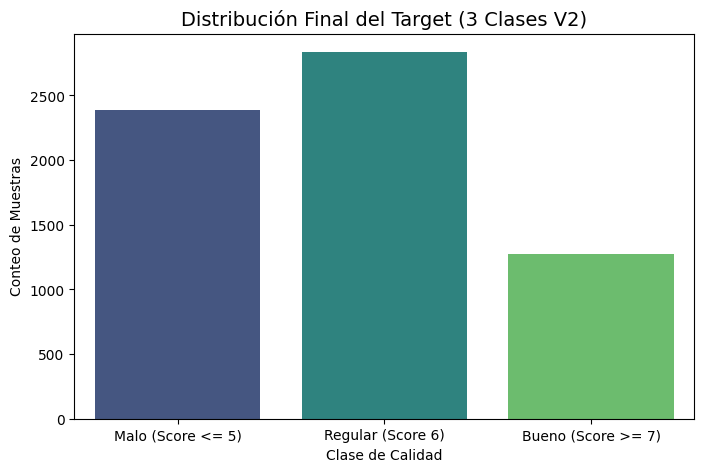

In [ ]:
# Distribución de clases desbalanceadas

# Mapeo para etiquetas:
class_labels = {0: "Malo (Score <= 5)", 1: "Regular (Score 6)", 2: "Bueno (Score >= 7)"}
df_vino_combinado['Etiqueta_Final'] = df_vino_combinado['quality_clase_final'].map(class_labels)

plt.figure(figsize=(8, 5))
sns.countplot(x='Etiqueta_Final', data=df_vino_combinado, palette="viridis")
plt.title('Distribución Final del Target (3 Clases V2)', fontsize=14)
plt.xlabel('Clase de Calidad')
plt.ylabel('Conteo de Muestras')
plt.show()

C:\Users\delam\AppData\Local\Temp\ipykernel_15032\2131431155.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_resampled, palette="viridis")


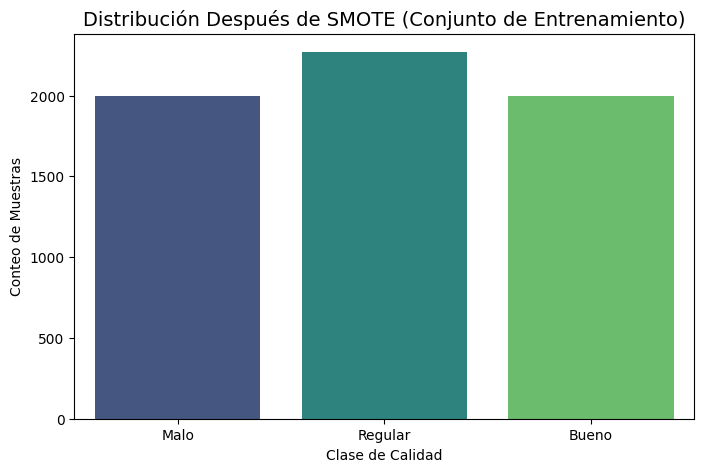

In [ ]:
# Clases equilibradas después de hacer Smote

plt.figure(figsize=(8, 5))
sns.countplot(x=y_train_resampled, palette="viridis")
plt.title('Distribución Después de SMOTE (Conjunto de Entrenamiento)', fontsize=14)
plt.xlabel('Clase de Calidad')
plt.ylabel('Conteo de Muestras')
plt.xticks(ticks=[0, 1, 2], labels=["Malo", "Regular", "Bueno"]) # Ajusta si usas 0, 1, 2
plt.show()

C:\Users\delam\AppData\Local\Temp\ipykernel_15032\4066224432.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr.values, y=target_corr.index, palette="coolwarm")


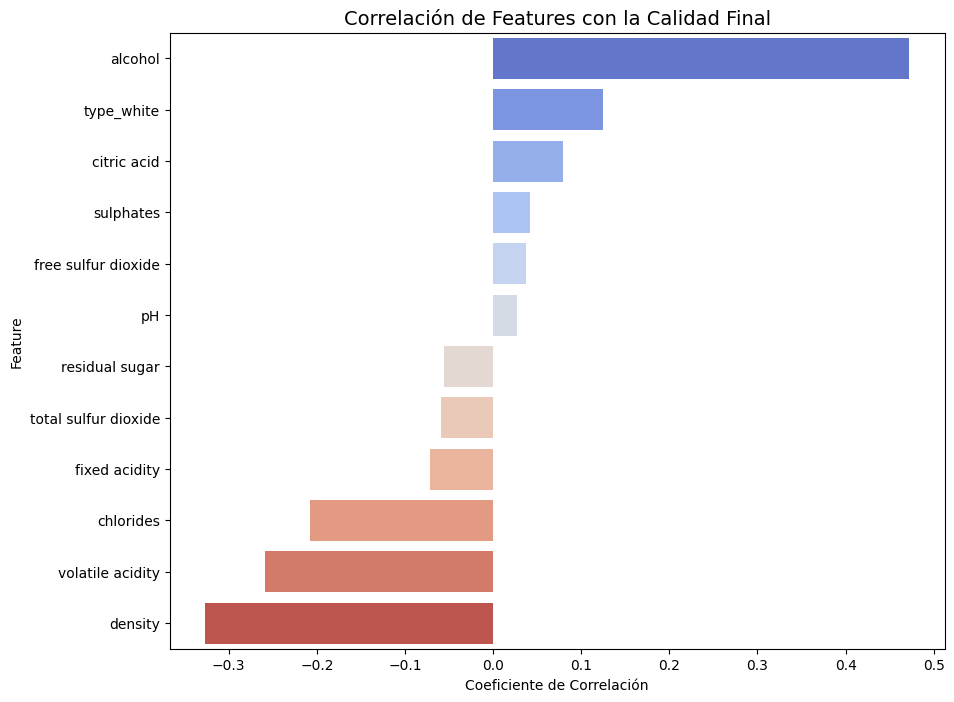

In [56]:
# 1. Crear una COPIA del DataFrame para la correlación
# Esto es importante para no modificar el DataFrame original si no lo deseas.
df_corr = df_vino_combinado.copy()

# 2. Aplicar One-Hot Encoding a la columna 'type'
# Esto crea la columna 'type_white' (o 'type_red') que es numérica (0 o 1).
df_corr = pd.get_dummies(df_corr, columns=['type'], drop_first=True)

# 3. Eliminar columnas que no son Features ni Target (si existen)
# Nos aseguramos de que solo queden números.
df_corr = df_corr.drop(columns=['quality_clase', 'quality_clase_5', 'Etiqueta_Final', 'quality_clase_4', 'quality'], errors='ignore')


# 4. Calcular la matriz de correlación (¡Ahora solo contiene números!)
# Usamos el target definitivo 'quality_clase_final' (que ya es numérico 0, 1, 2)
corr_matrix = df_corr.corr()

plt.figure(figsize=(10, 8))
# Usamos el target final para el análisis
target_corr = corr_matrix['quality_clase_final'].sort_values(ascending=False).drop('quality_clase_final') 

sns.barplot(x=target_corr.values, y=target_corr.index, palette="coolwarm")
plt.title('Correlación de Features con la Calidad Final', fontsize=14)
plt.xlabel('Coeficiente de Correlación')
plt.ylabel('Feature')
plt.show()

In [61]:
# --- INICIO DEL CÓDIGO A EJECUTAR ---

# Paso 1: Separación de Datos (Usando el Nuevo Target)
# ---------------------------------------------------
# Definir Features (X) y Target (y)
# NOTA: Asegúrate de que las columnas a eliminar existan en tu DF.
X = df_vino_combinado.drop(columns=['quality', 'quality_clase_5', 'quality_clase_4', 'quality_clase_final', 'Etiqueta_Final']) 
y = df_vino_combinado['quality_clase_final'] # Target de 3 clases V2

# Aplicar One-Hot Encoding a la variable 'type' (es crucial para X)
X = pd.get_dummies(X, columns=['type'], drop_first=True) 

# Separación Entrenamiento/Prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Paso 2: Aplicación de SMOTE
# ---------------------------
smote_strategy = {
    0: 2000, # Malo
    1: 2269, # Regular (Conteo aproximado original en train set)
    2: 2000  # Bueno
}

sm = SMOTE(sampling_strategy=smote_strategy, random_state=42)

X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)


# Paso 3: Reentrenamiento del Modelo Campeón y Generación del Reporte
# ------------------------------------------------------------------
parametros_optimos_ada = {
    'n_estimators': 200, 
    'estimator__max_leaf_nodes': 500, 
    'estimator__max_depth': 30
}

# 1. Recrear y Entrenar el modelo
ada_final_v2 = AdaBoostRegressor(
    DecisionTreeRegressor(max_leaf_nodes=parametros_optimos_ada['estimator__max_leaf_nodes'], 
                          max_depth=parametros_optimos_ada['estimator__max_depth'], 
                          random_state=42),
    n_estimators=parametros_optimos_ada['n_estimators'], 
    random_state=42
)

ada_final_v2.fit(X_train_resampled, y_train_resampled)

# 2. Generar predicciones (y_pred_final_v2)
y_pred_cont = ada_final_v2.predict(X_test)
y_pred_final_v2 = np.rint(y_pred_cont).astype(int)
y_pred_final_v2 = np.clip(y_pred_final_v2, 0, 2) # Aseguramos el rango [0, 2]

# 3. Mostrar Reporte de Clasificación (El objetivo de esta re-ejecución)
print("\nReporte de Clasificación (3 Clases V2) AdaBoost Optimizado:")
print(classification_report(y_test, y_pred_final_v2, zero_division=0))


Reporte de Clasificación (3 Clases V2) AdaBoost Optimizado:
              precision    recall  f1-score   support

           0       0.81      0.71      0.76       477
           1       0.66      0.76      0.71       567
           2       0.71      0.64      0.68       256

    accuracy                           0.72      1300
   macro avg       0.73      0.70      0.71      1300
weighted avg       0.72      0.72      0.72      1300



C:\Users\delam\AppData\Local\Temp\ipykernel_15032\2893410751.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_report_clases.index, y='f1-score', data=df_report_clases, palette="magma")


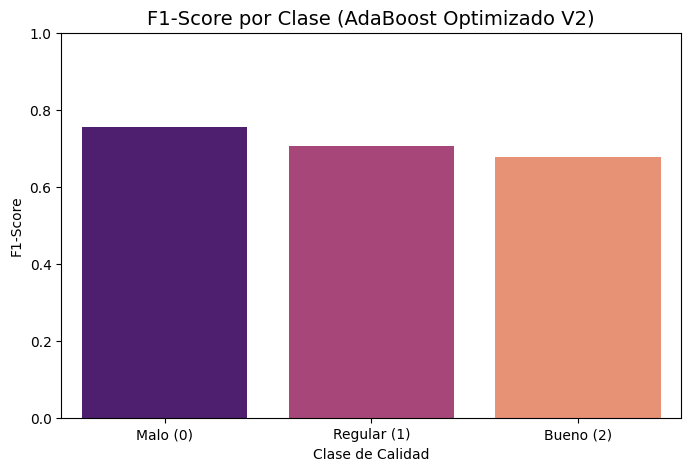

In [63]:


# **IMPORTANTE:** Asegúrate de que y_test y y_pred_final_v2 ya han sido generados con el código anterior.

# 1. Generar el reporte de clasificación como diccionario
report = classification_report(y_test, y_pred_final_v2, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report).transpose()

# 2. SELECCIONAR solo las filas de las clases (excluir 'accuracy', 'macro avg', 'weighted avg')
# Los nombres de las filas en el reporte son '0', '1', '2' (como strings)
df_report_clases = df_report.loc[['0', '1', '2']]

# 3. Mapeo de etiquetas para el gráfico
df_report_clases.index = ["Malo (0)", "Regular (1)", "Bueno (2)"]

plt.figure(figsize=(8, 5))
# Usamos el DataFrame filtrado df_report_clases
sns.barplot(x=df_report_clases.index, y='f1-score', data=df_report_clases, palette="magma")
plt.title('F1-Score por Clase (AdaBoost Optimizado V2)', fontsize=14)
plt.xlabel('Clase de Calidad')
plt.ylabel('F1-Score')
plt.ylim(0.0, 1.0)
plt.show()

C:\Users\delam\AppData\Local\Temp\ipykernel_15032\3113519602.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='quality', data=df_vino_combinado, palette="magma")


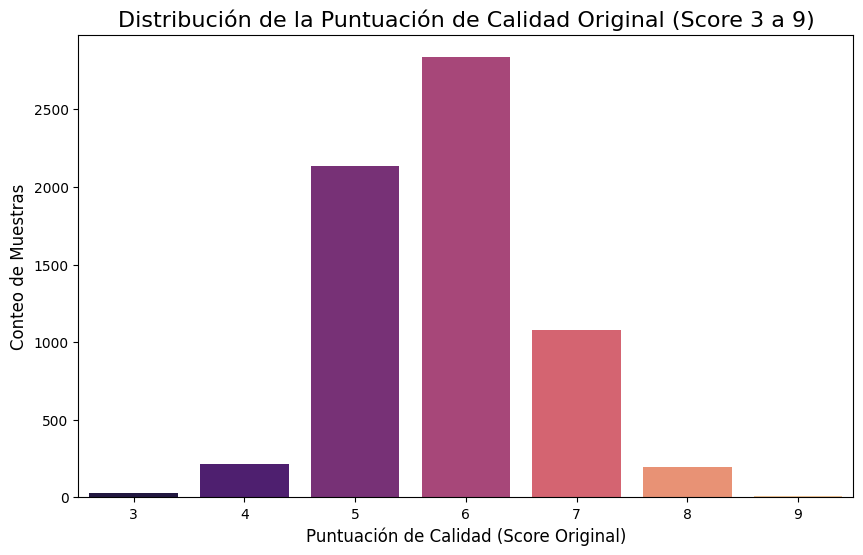

In [64]:
plt.figure(figsize=(10, 6))

# Usamos la columna 'quality' (puntuación original de 3 a 9)
sns.countplot(x='quality', data=df_vino_combinado, palette="magma")

plt.title('Distribución de la Puntuación de Calidad Original (Score 3 a 9)', fontsize=16)
plt.xlabel('Puntuación de Calidad (Score Original)', fontsize=12)
plt.ylabel('Conteo de Muestras', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

C:\Users\delam\AppData\Local\Temp\ipykernel_15032\3863277962.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='cividis')


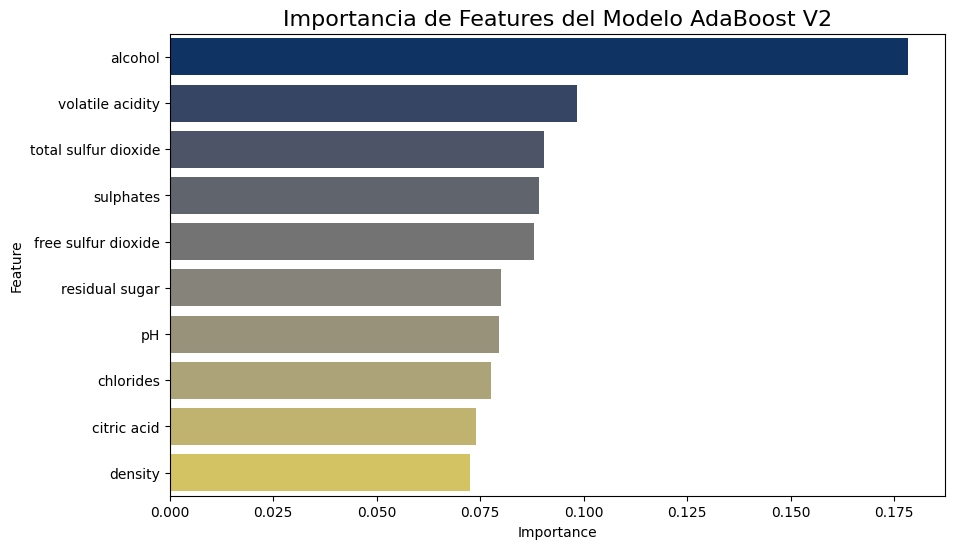


Top 5 Features por Importancia:
                 Feature  Importance
10               alcohol    0.178280
1       volatile acidity    0.098304
6   total sulfur dioxide    0.090443
9              sulphates    0.089128
5    free sulfur dioxide    0.088032


In [65]:
# 1. Extraer la importancia de features
importances = ada_final_v2.feature_importances_

# 2. Asignar los nombres de las features a las importancias
# ¡CRÍTICO!: Asegúrate de que X.columns refleje el DataFrame X que usaste para entrenar
feature_names = X_train_resampled.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names, 
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 3. Mostrar el gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='cividis')
plt.title('Importancia de Features del Modelo AdaBoost V2', fontsize=16)
plt.show()

# Opcional: Imprimir los valores exactos
print("\nTop 5 Features por Importancia:")
print(feature_importance_df.head())

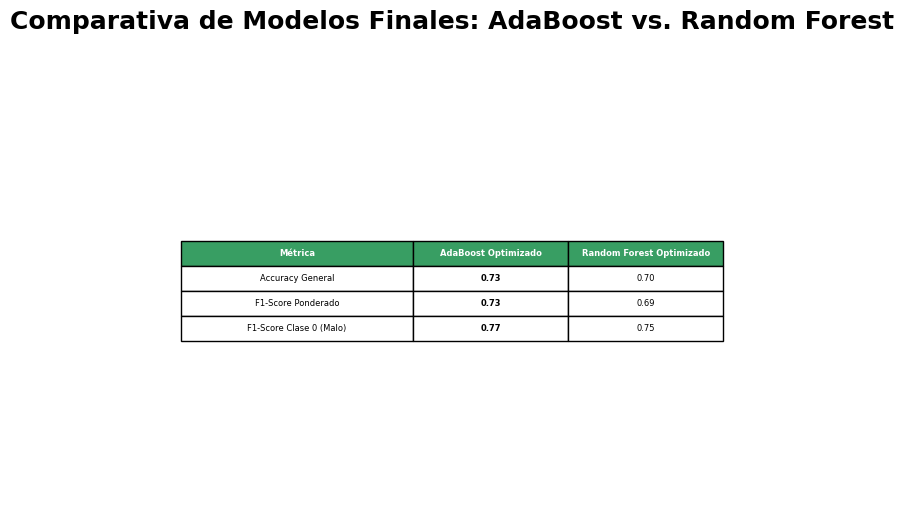

In [ ]:
# 1. Definir los datos de la tabla
data = {
    'Métrica': ['Accuracy General', 'F1-Score Ponderado', 'F1-Score Clase 0 (Malo)'],
    'AdaBoost Optimizado': ['0.73', '0.73', '0.77'],
    'Random Forest Optimizado': ['0.70', '0.69', '0.75']
}
df_comparacion = pd.DataFrame(data)

# 2. Configuración de Matplotlib para la tabla
# Aumentamos la altura vertical del figsize (ej. de 4 a 6) para dar espacio al contenido
fig, ax = plt.subplots(figsize=(10, 6)) # <-- AJUSTE CLAVE DE ALTURA AQUÍ
ax.axis('tight')
ax.axis('off') # Ocultar ejes

# 3. Crear la tabla visual
table = ax.table(cellText=df_comparacion.values, 
                 colLabels=df_comparacion.columns, 
                 cellLoc = 'center', 
                 loc='center',
                 colWidths=[0.3, 0.2, 0.2]) 

# 4. Ajuste de Estilo y Alto (Aumentando la Fuente)
for (i, j), cell in table.get_celld().items():
    if i == 0: # Encabezado
        cell.set_facecolor("#389e63")
        cell.set_fontsize(18) # <-- Fuente más grande para el encabezado (lo obliga a ser más alto)
        cell.set_text_props(weight='bold', color='white')
    else: # Cuerpo de la tabla
        cell.set_fontsize(16) # <-- Fuente más grande para el cuerpo (lo obliga a ser más alto)
        
        # Resaltar la columna ganadora (AdaBoost)
        if j == 1: 
            cell.set_text_props(weight='bold')
            
# 5. Ajustar el espaciado interno de las celdas
# Esta función es la que realmente obliga a las celdas a expandirse internamente.
table.set_fontsize(16) # Tamaño general de la fuente
table.scale(1, 1.5) # <-- AJUSTE CLAVE: Escalar la tabla verticalmente (1.5 veces su altura original)

# Añadir título
plt.title('Comparativa de Modelos Finales: AdaBoost vs. Random Forest', y=1.05, fontsize=18, weight='bold')


# 6. Guardar la tabla como imagen
plt.savefig('comparativa_modelos_campeon_alto.png', bbox_inches='tight', dpi=300)

plt.show()